### Single-input Network - PyTorch

Predicts the action given a single observation (checks whether the Dataset is 'difficult' to learn)

In [11]:
'''
Imports external and own libraries
'''

import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

from prettytable import PrettyTable

# own
import collector
import action
import world
import plot
import preprocess
import nets
import train

In [2]:
'''
Load data with pickle (deserialize)
'''
with open('datasets/oracle_data.pickle', 'rb') as handle:
    oracle_data = pickle.load(handle)

with open('datasets/oracle_reversed_data.pickle', 'rb') as handle:
    oracle_reversed_data = pickle.load(handle)

with open('datasets/oracle_random_data.pickle', 'rb') as handle:
    oracle_random_data = pickle.load(handle)

with open('datasets/oracle_reversed_random_data.pickle', 'rb') as handle:
    oracle_reversed_random_data = pickle.load(handle)
    
with open('datasets/random_data.pickle', 'rb') as handle:
    random_data = pickle.load(handle)

In [4]:
'''
Use Dataloader to make the data ready for the training loop
'''

train_data, test_data = preprocess.split_data(oracle_reversed_data, 0.8)

# preprocess trainingset 
oracle_train_data = preprocess.ObtainDataset(train_data, 'observations', 'actions')
oracle_test_data = preprocess.ObtainDataset(test_data, 'observations', 'actions')

# build dataloader (tensor format)
batch_size = 64
dataset_loader_train_data = DataLoader(oracle_train_data, batch_size=batch_size, shuffle=True)
dataset_loader_test_data = DataLoader(oracle_test_data, batch_size=batch_size, shuffle=True)

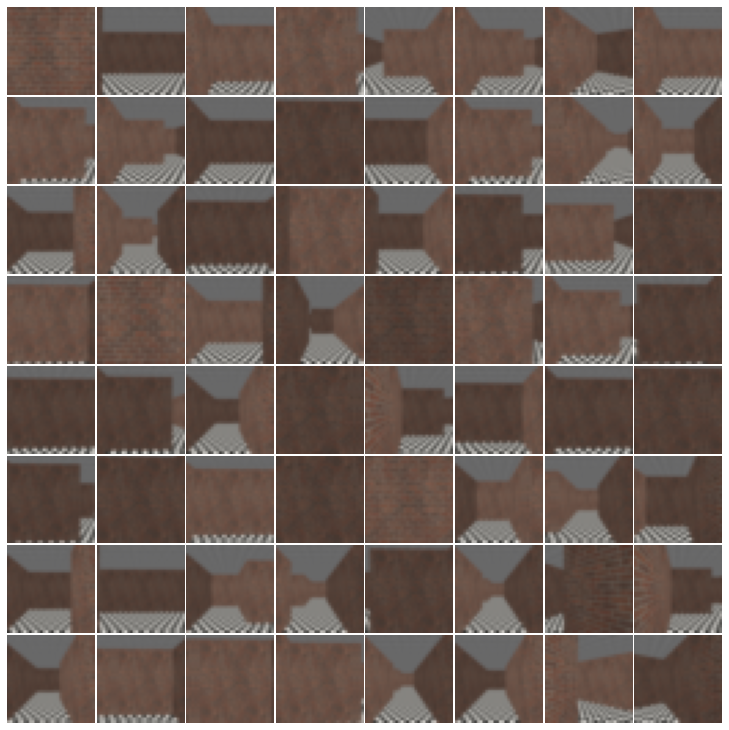

In [5]:
'''
Visualize one batch
'''

# next data part
dataiter = iter(dataset_loader_train_data)
# plot 64 examples
images, labels = dataiter.next()
plot.plot_64_observations(images)

In [6]:
'''
Feed-forward network
'''

forward = nets.Forward()
summary(forward, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 4]             340
Total params: 61,496
Trainable params: 61,496
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.23
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [15]:
'''
Train the network
'''
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(forward.parameters(), lr=0.01, momentum=0.9) # for small one 0.01 works well

episodes = 100
model, test_loss, train_loss, test_acc, train_acc  = train.train(dataset_loader_train_data, dataset_loader_test_data, forward, criterion, optimizer, episodes)


Progress:   0%|          | 0/100 [00:00<?, ? Episode/s]

Epoch: 1, Train Loss: 277.8, Train Acc: 34 %,  Test Loss: 10.25, Test Acc: 42 %,


KeyboardInterrupt: 

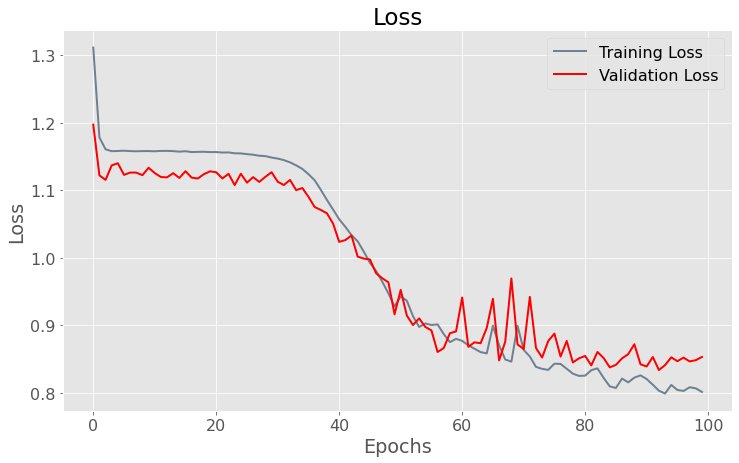

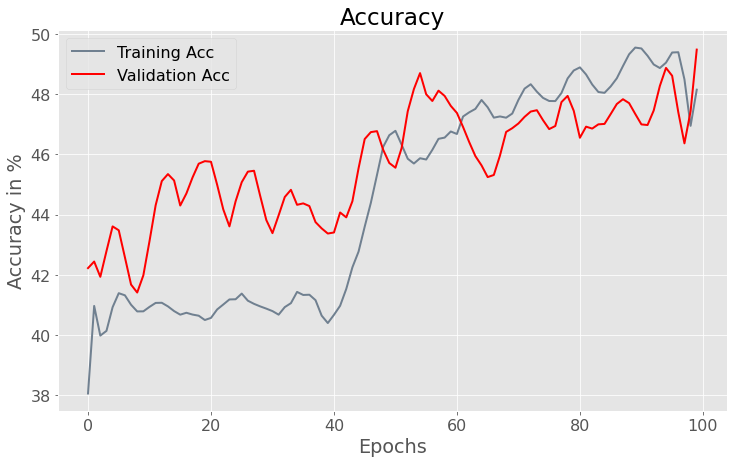

In [14]:
'''
Plot loss and accuracy curves for training and test set
'''

plot.plot_losses(test_loss, train_loss)
plot.plot_acc(test_acc, train_acc, smooth=True)

GroundTruth:  walk backwards, turn left, turn right, walk backwards, walk backwards, walk backwards, walk backwards, walk forwards
Predicted:  walk backwards, turn left, walk backwards, walk backwards, walk backwards, walk backwards, walk backwards, walk backwards 



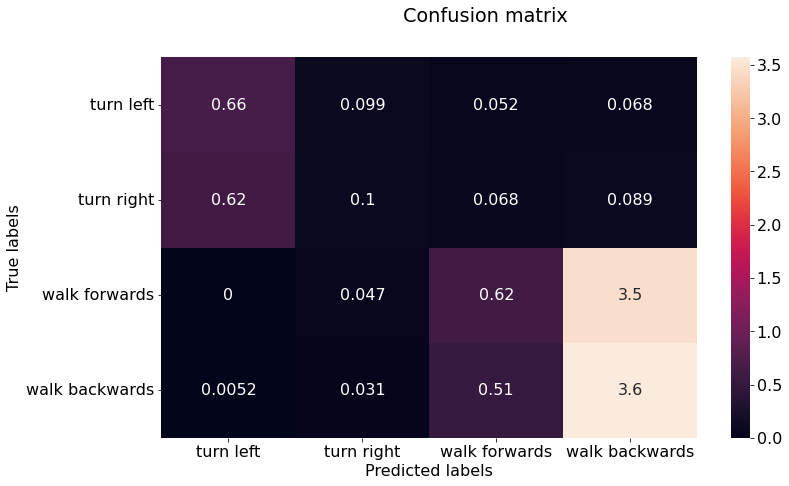

In [9]:
'''
Show example classifications and plot confusion matrix
'''

plot.show_example_classificataions(dataset_loader_train_data, model, amount=8)
plot.plot_confusion_matrix(dataset_loader_train_data, model)

In [13]:
'''
Save and load model
'''

# Save
torch.save(model, 'models/Feedforward.pt')

# Load
model = torch.load('models/Feedforward.pt')
model.eval()

Forward(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)